In [1]:
with open('corpus_file.txt', 'r') as corpus_file:
    corpus_list = corpus_file.read().splitlines()
corpus_list[0]

'000051650-1_1_1'

In [2]:
val_split = 0.1
val_idx = int(len(corpus_list) * val_split)
training_list = corpus_list[val_idx:]
validation_list = corpus_list[:val_idx]

# training_list[0]

temp = []
for item in validation_list:
    temp.append("D " + item)
validation_list = temp

# training_list = corpus_list[1000:11000]
# validation_list = corpus_list[:1000]
# temp_validation_list = []

print(len(validation_list))
#Selectively choosing tests based on length:
# for item in validation_list:
#     with open('DataMach5/Primus/' + item + '/' + item + '.semantic', 'r') as sample_gt_file:
#         sample_gt_words = sample_gt_file.readline().rstrip().split('\t')
#         if len(sample_gt_words) <= 20:
#             temp_validation_list.append(item)
        
# validation_list = temp_validation_list
# print(len(validation_list))

temp = []
for item in training_list:
    temp.append("D " + item)
training_list += temp
print(len(training_list))

training_list[0]

8767
157822


'000107696-1_1_1'

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class PrimusDataset(Dataset):
    def __init__(self, root_dir, distorted_dir, df, processor, tokenizer, max_target_length=256, semantic=True):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length
        self.semantic = semantic
        self.distorted_dir = distorted_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df[idx]
        isDistorted = False
        if file_name[0] == 'D':
            file_name =  file_name[2:]
            isDistorted = True
        
        sample_fullpath = self.root_dir + '/' + file_name + '/' + file_name
        if not self.semantic:
            sample_gt_fullpath = 'Agnostic_encoding/' + file_name + '/' + file_name + '.agnostic'
        else:
            sample_gt_fullpath = sample_fullpath + '.semantic'
        
        with open(sample_gt_fullpath, 'r') as sample_gt_file:
            sample_gt_words = sample_gt_file.readline().rstrip().split(self.word_separator())
            sample_gt_plain = ' '.join(sample_gt_words)
        
        if isDistorted:
            image = Image.open(self.distorted_dir + file_name + '/' + file_name + '_distorted.jpg').convert('RGB')
        else:
            image = Image.open(sample_fullpath + '.png').convert('RGB')
        
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        labels = self.tokenizer.tokenize(sample_gt_plain, 
                                          max_length=self.max_target_length)

        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
#         print(encoding)
        return encoding

    @staticmethod
    def word_separator():
        return '\t'
    
#     @staticmethod
#     def resize(image, height):
#         aspect_ratio = image.width / image.height
#         new_width = int(aspect_ratio * height)
#         resized_image = image.resize((new_width, height), Image.LANCZOS)
#         return resized_image


In [4]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("microsoft/trocr-base-printed")

# word2int = {}

# dict_file = open('Data/vocabulary_semantic.txt','r')
# dict_list = dict_file.read().splitlines()
# i=0
# for word in dict_list:
#     if not word in word2int:
#         word2int[word] = i
#         i+=1

# dict_file.close()
# new_tokens = set(word2int) - set(tokenizer.vocab.keys())
# tokenizer.add_tokens(list(new_tokens))

In [5]:
class SimpleTokenizer:
    def __init__(self, vocab, pad_token='<pad>', start_token='<s>', end_token='</s>'):
        self.vocab = vocab
        self.pad_token_id = vocab[pad_token]
        self.cls_token_id = vocab[start_token]
        self.sep_token_id = vocab[end_token]
        self.inverse_vocab = {v: k for k, v in vocab.items()}

    def tokenize(self, text, max_length=None):
        token_ids = []
        
        token_ids.append(self.cls_token_id)
        
        token_ids.extend(self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in text.split())

        token_ids.append(self.sep_token_id)
        
        if max_length is not None:
            padding_length = max(0, max_length - len(token_ids))
            token_ids.extend([self.pad_token_id] * padding_length)
        
        return token_ids

    def detokenize(self, token_ids):
        # Converts a list of token IDs back to a string
        # Remove special characters
        assert isinstance(token_ids, list), "token_ids must be a list"
        tokens = [self.inverse_vocab[token_id] for token_id in token_ids if token_id in self.inverse_vocab and token_id not in [self.cls_token_id, self.sep_token_id, self.pad_token_id]]
        return ' '.join(tokens)
    
    def batch_decode(self, batch_token_ids):
        assert isinstance(batch_token_ids, list), "batch_token_ids must be a list"
        decoded_strings = []
        for token_ids in batch_token_ids:
            decoded_strings.append(self.detokenize(token_ids))
        return decoded_strings

dict_file = open('vocabulary_semantic_modified.txt','r')
# dict_file = open('vocabulary_agnostic_modified.txt','r')
dict_list = dict_file.read().splitlines()
print(list(dict_list)[:10])
dict_file.close()
vocab = {tok: i for i, tok in enumerate(dict_list)}
tokenizer = SimpleTokenizer(vocab)
text = "barline tie clef-C2"
# text = "accidental.flat-L4 dot-S-2"
token_ids = tokenizer.tokenize(text, max_length=256)
print(token_ids)
detokenized_text = tokenizer.detokenize(token_ids)
print("Detokenized text: ", detokenized_text)

['<s>', '<pad>', '</s>', '<unk>', 'barline', 'clef-C1', 'clef-C2', 'clef-C3', 'clef-C4', 'clef-C5']
[0, 4, 1745, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Detokenized text:  barline tie clef-C2


In [6]:
from transformers import TrOCRProcessor
from transformers import AutoTokenizer

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
# processor.feature_extractor.size = (512, 512)
# tokenizer = AutoTokenizer.from_pretrained('tokenizer-small-new-only')

train_dataset = PrimusDataset(root_dir='DataMach5/Primus',
                            distorted_dir='CamPrIMuS/',
                           df=training_list,
                           processor=processor,
                            tokenizer=tokenizer)
val_dataset = PrimusDataset(root_dir='DataMach5/Primus',
                            distorted_dir='CamPrIMuS/',
                           df=validation_list,
                           processor=processor,
                           tokenizer=tokenizer)

/localscratch/bisman.18554872.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 157822
Number of validation examples: 8767


In [8]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([256])


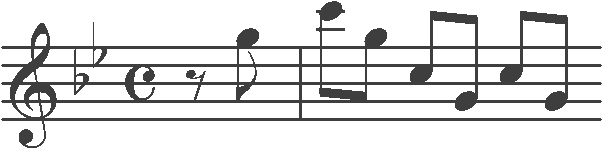

In [9]:
image = Image.open(train_dataset.root_dir + '/' + training_list[0] + '/' + training_list[0] + '.png').convert("RGB")
image

In [10]:
labels = encoding['labels']

labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.detokenize(labels.tolist())
print(label_str)

clef-G2 keySignature-BbM timeSignature-C rest-eighth note-G5_eighth barline note-C6_eighth note-G5_eighth note-C5_eighth note-G4_eighth note-C5_eighth note-G4_eighth


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64 ,shuffle=True, num_workers = 12)
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers = 12)

In [12]:
import jiwer

# Example usage
reference = "clef-G2 keySignature-BbM   timeSignature-C rest-eighth note-G5_eighth barline note-C6_eighth note-G5_eighth note-C5_eighth note-G4_eighth note-C5_eighth note-G4_eighth"
hypothesis = " clef-G2   keySignature-BbM"

wer = jiwer.wer(reference, hypothesis)
print("Word Error Rate:", wer)

Word Error Rate: 0.8333333333333334


In [13]:
from transformers import VisionEncoderDecoderModel
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# import math
# import torch.nn.functional as F
# def resize_pos_embed(posemb, new_image_size, patch_size):
#     # Calculate the number of patches for the new image size
#     new_grid_height = new_image_size[0] // patch_size
#     new_grid_width = new_image_size[1] // patch_size
#     new_num_patches = new_grid_height * new_grid_width

#     cls_token_emb = posemb[:, :2, :]
#     posemb_grid = posemb[:, 2:, :]  # Exclude the CLS token

#     # Calculate the grid size of the original posemb
#     gs_old = int(math.sqrt(posemb_grid.shape[1]))
    
#     print("before initial reshaping", posemb_grid.shape)

#     # Reshape to [1, embedding_dim, height, width]
#     posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
#     print("before interpolate", posemb_grid.shape)

#     # Resize to the new grid size
#     posemb_grid = F.interpolate(posemb_grid, size=(new_grid_height, new_grid_width), mode='bicubic', align_corners=False)
    
#     print("after interpolate", posemb_grid.shape)
    
#     # Reshape back to [1, num_patches, embedding_dim]
#     posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, new_grid_height*new_grid_width,-1)
    
#     print("after reshaping", posemb_grid.shape)
#     # Concatenate with the CLS token embedding
#     new_posemb = torch.cat([cls_token_emb, posemb_grid], dim=1)
#     return new_posemb

In [16]:
from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel, DeiTConfig, TrOCRForCausalLM

# model = VisionEncoderDecoderModel.from_pretrained("model_trocr-small-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
# config = VisionEncoderDecoderConfig.from_pretrained("model_trocr-small-stage1")


# decoder = BartModel.from_pretrained("decoder-BART").decoder
# encoder = VisionEncoderDecoderModel.from_pretrained("model_trocr-small-stage1").encoder
# model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)
# config = VisionEncoderDecoderConfig.from_pretrained("model_trocr-small-stage1")
# model = VisionEncoderDecoderModel(config)

# replace_relu_with_leaky_relu(model)
model.decoder.resize_token_embeddings(len(tokenizer.vocab))
# model.encoder.encoder.layer = nn.ModuleList(model.encoder.encoder.layer[:-6])
# print(model.config.encoder.num_hidden_layers)
# model.config.encoder.num_hidden_layers = 6
# model.decoder.layers = nn.ModuleList(model.decoder.layers[:6])
# print(model.config.decoder.num_hidden_layers)
# model.config.decoder.num_hidden_layers = 6
model= nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): VisionEncoderDecoderModel(
    (encoder): DeiTModel(
      (embeddings): DeiTEmbeddings(
        (patch_embeddings): DeiTPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): DeiTEncoder(
        (layer): ModuleList(
          (0-11): 12 x DeiTLayer(
            (attention): DeiTAttention(
              (attention): DeiTSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): DeiTSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
  

In [15]:
# from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel, DeiTModel

# encoder = VisionEncoderDecoderModel.from_pretrained("model_trocr-small-stage1").encoder
# state_dict = encoder.state_dict()
# config = VisionEncoderDecoderConfig.from_pretrained("model_trocr-small-stage1").encoder
# config.image_size = (512,512)
# new_encoder = DeiTModel(config=config)

# # update state_dict
# new_state_dict = state_dict.copy()
# old_posemb = new_state_dict['embeddings.position_embeddings']
# print(old_posemb.shape)
# new_posemb = resize_pos_embed(old_posemb, new_image_size=(512, 512), patch_size=16) # use PyTorch function linked above
# print(new_posemb.shape)
# new_state_dict['embeddings.position_embeddings'] = new_posemb
# new_encoder.load_state_dict(new_state_dict)

# decoder = VisionEncoderDecoderModel.from_pretrained("model_trocr-small-stage1").decoder
# model = VisionEncoderDecoderModel(encoder=new_encoder, decoder=decoder)
# print(model.encoder.embeddings.position_embeddings.shape)
# # Load the model with the updated configuration
# model.decoder.resize_token_embeddings(len(tokenizer))
# # model.encoder.encoder.layer = nn.ModuleList(model.encoder.encoder.layer[:-8])
# # model.decoder.model.decoder.layers = nn.ModuleList(model.decoder.model.decoder.layers[:-8])
# model= nn.DataParallel(model)
# model.to(device)

In [16]:
def compute_wer(pred_ids_list, label_ids_list):
    pred_ids_list = pred_ids_list.tolist()
    label_ids_list = label_ids_list.tolist()

    total_wer = 0
    total_errors = 0
    for pred_ids, label_ids in zip(pred_ids_list, label_ids_list):
        pred_str = tokenizer.detokenize(pred_ids)
        label_ids[label_ids == -100] = tokenizer.pad_token_id  # Handle ignore index
        label_str = tokenizer.detokenize(label_ids)
        temp = jiwer.wer(label_str, pred_str)
        total_wer += temp
        if temp > 0 :
            total_errors += 1
        
    average_wer = total_wer / len(pred_ids_list)

    return (average_wer , total_errors)

In [17]:
len(val_dataloader)

137

In [20]:
model.module.config.decoder_start_token_id = tokenizer.cls_token_id
model.module.config.pad_token_id = tokenizer.pad_token_id
model.module.config.vocab_size = model.module.config.decoder.vocab_size


model.module.config.eos_token_id = tokenizer.sep_token_id
model.module.config.max_length = 256
model.module.config.early_stopping = True
model.module.config.no_repeat_ngram_size = 6
model.module.config.length_penalty = 6.0
model.module.config.num_beams = 4

In [18]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

for epoch in range(80):  #Change back to (40)
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
#       print(batch)
      for k,v in batch.items():
        batch[k] = v.to(device)
      # outputs = model(**batch)
      outputs = model(pixel_values=batch['pixel_values'], labels=batch['labels'])
      loss = outputs.loss
      loss=loss.mean()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
   display_result = f" Loss after epoch {epoch+1}: {train_loss/len(train_dataloader)}"
   print(display_result)
   model.module.save_pretrained(f"epoch_mach3_base4/epoch_{epoch + 1}")
   with open("epoch_mach3_base4/results.txt", "a") as myfile:
        myfile.write(display_result)
    
   # validation
   model.eval()
   valid_wer = 0.0
   valid_seq_err = 0
   with torch.no_grad():
     for batch in tqdm(val_dataloader):
       # run batch generation
       outputs = model.module.generate(batch["pixel_values"].to(device))
       # compute WER (or SER)
       wer, seq_err = compute_wer(pred_ids_list=outputs, label_ids_list=batch["labels"])
       valid_seq_err += seq_err
       valid_wer += wer 
   scheduler.step(valid_wer / len(val_dataloader))
   print("val dataloader length", len(val_dataloader))
   display_result = f"Validation SER after epoch {epoch+1}: {valid_wer / len(val_dataloader)}\nSequences with error(s): {valid_seq_err}\n"
   print(display_result)
   with open("epoch_mach3_base4/results.txt", "a") as myfile:
        myfile.write(display_result)

model.module.save_pretrained("./trained_model")

  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [34:17<00:00,  1.20it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model'

 Loss after epoch 1: 3.589105556481076


  0%|          | 0/137 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
100%|██████████| 2466/2466 [42:25<00:00,  1.03s/it]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 14: 0.10017038401841682


100%|██████████| 137/137 [09:59<00:00,  4.38s/it]


val dataloader length 137
Validation SER after epoch 14: 0.0330972482209662
Sequences with error(s): 2935



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [45:11<00:00,  1.10s/it]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 15: 0.08912769914887972


100%|██████████| 137/137 [10:08<00:00,  4.44s/it]


val dataloader length 137
Validation SER after epoch 15: 0.028448373769031206
Sequences with error(s): 2664



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [35:11<00:00,  1.17it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 16: 0.07859715307320242


100%|██████████| 137/137 [10:43<00:00,  4.70s/it]


val dataloader length 137
Validation SER after epoch 16: 0.02675870801385226
Sequences with error(s): 2536



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [34:46<00:00,  1.18it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 17: 0.07159653272923906


100%|██████████| 137/137 [09:48<00:00,  4.30s/it]


val dataloader length 137
Validation SER after epoch 17: 0.026185994428636755
Sequences with error(s): 2487



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [36:10<00:00,  1.14it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 18: 0.0643137203663926


100%|██████████| 137/137 [10:16<00:00,  4.50s/it]


val dataloader length 137
Validation SER after epoch 18: 0.025920640845020333
Sequences with error(s): 2533



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [36:24<00:00,  1.13it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 19: 0.06564850973256918


100%|██████████| 137/137 [09:49<00:00,  4.30s/it]


val dataloader length 137
Validation SER after epoch 19: 0.02998853328274336
Sequences with error(s): 2817



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [37:34<00:00,  1.09it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 20: 0.0499016236984424


100%|██████████| 137/137 [09:58<00:00,  4.37s/it]


val dataloader length 137
Validation SER after epoch 20: 0.030499680073096298
Sequences with error(s): 2919



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [36:14<00:00,  1.13it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 30: 0.027781858674491493


100%|██████████| 137/137 [09:51<00:00,  4.32s/it]


val dataloader length 137
Validation SER after epoch 30: 0.022338010209938246
Sequences with error(s): 2241



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [33:38<00:00,  1.22it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 31: 0.015299469274102384


100%|██████████| 137/137 [09:27<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 31: 0.019357132495114136
Sequences with error(s): 1994



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [32:19<00:00,  1.27it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 32: 0.014068745656655791


100%|██████████| 137/137 [09:39<00:00,  4.23s/it]


val dataloader length 137
Validation SER after epoch 32: 0.01879812035326849
Sequences with error(s): 1951



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 28%|██▊       | 698/2466 [09:20<19:18,  1.53it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 137/137 [09:31<00:00,  4.17s/it]


val dataloader length 137
Validation SER after epoch 33: 0.018414213311928298
Sequences with error(s): 1914



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [31:51<00:00,  1.29it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 34: 0.012725740090639096


100%|██████████| 137/137 [09:29<00:00,  4.16s/it]


val dataloader length 137
Validation SER after epoch 34: 0.01895560324165666
Sequences with error(s): 1965



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [36:19<00:00,  1.13it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 35: 0.012283540798943348


100%|██████████| 137/137 [09:31<00:00,  4.17s/it]


val dataloader length 137
Validation SER after epoch 35: 0.018740226114244536
Sequences with error(s): 1942



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [36:47<00:00,  1.12it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 36: 0.011906339270347881


100%|██████████| 137/137 [09:26<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 36: 0.018493398223403307
Sequences with error(s): 1918



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [31:39<00:00,  1.30it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 65: 0.009937709641300327


100%|██████████| 137/137 [09:25<00:00,  4.13s/it]


val dataloader length 137
Validation SER after epoch 65: 0.018477441658884396
Sequences with error(s): 1919



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [30:50<00:00,  1.33it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 66: 0.009909846195326068


100%|██████████| 137/137 [09:24<00:00,  4.12s/it]


val dataloader length 137
Validation SER after epoch 66: 0.01851758302839631
Sequences with error(s): 1921



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [30:56<00:00,  1.33it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 67: 0.009918985849320782


100%|██████████| 137/137 [09:26<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 67: 0.0184719300504211
Sequences with error(s): 1920



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [33:48<00:00,  1.22it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 68: 0.009919977700026193


100%|██████████| 137/137 [09:43<00:00,  4.26s/it]


val dataloader length 137
Validation SER after epoch 68: 0.018505984590216493
Sequences with error(s): 1921



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [35:20<00:00,  1.16it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 69: 0.009963344874882818


100%|██████████| 137/137 [09:27<00:00,  4.15s/it]


val dataloader length 137
Validation SER after epoch 69: 0.018415069475524133
Sequences with error(s): 1913



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [31:13<00:00,  1.32it/s] 
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 70: 0.009930593622476391


100%|██████████| 137/137 [09:27<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 70: 0.01847088706228133
Sequences with error(s): 1922



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [28:34<00:00,  1.44it/s] 
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 71: 0.00990409939634838


100%|██████████| 137/137 [09:27<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 71: 0.01843828456336233
Sequences with error(s): 1918



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 137/137 [09:32<00:00,  4.18s/it]s] 


val dataloader length 137
Validation SER after epoch 73: 0.018447400425934554
Sequences with error(s): 1921



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [32:59<00:00,  1.25it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 74: 0.00989196885863224


100%|██████████| 137/137 [09:29<00:00,  4.15s/it]


val dataloader length 137
Validation SER after epoch 74: 0.01844637343157675
Sequences with error(s): 1920



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [29:34<00:00,  1.39it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 75: 0.009907520830854834


100%|██████████| 137/137 [09:26<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 75: 0.018501565650363594
Sequences with error(s): 1923



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [31:36<00:00,  1.30it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 76: 0.00990074714596647


100%|██████████| 137/137 [09:25<00:00,  4.13s/it]


val dataloader length 137
Validation SER after epoch 76: 0.018470618774115932
Sequences with error(s): 1923



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [32:21<00:00,  1.27it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 77: 0.009934617860381705


100%|██████████| 137/137 [10:06<00:00,  4.43s/it]


val dataloader length 137
Validation SER after epoch 77: 0.018482229426531726
Sequences with error(s): 1920



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 2466/2466 [34:01<00:00,  1.21it/s]  
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 6.0, 'no_repeat_ngram_size': 6}


 Loss after epoch 78: 0.009866631447733362


100%|██████████| 137/137 [09:27<00:00,  4.14s/it]


val dataloader length 137
Validation SER after epoch 78: 0.0184165717970736
Sequences with error(s): 1914



  0%|          | 0/2466 [00:00<?, ?it/s]/localscratch/bisman.18348683.0/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 61%|██████    | 1509/2466 [19:27<10:18,  1.55it/s]  

In [ ]:
# next(iter(train_dataloader))

In [ ]:
# import torch
# print(torch.__version__)

In [19]:
# from transformers import VisionEncoderDecoderModel
# from tqdm import tqdm
# tempmodel = VisionEncoderDecoderModel.from_pretrained("epoch_mach3_base4/epoch_41")
# print(tempmodel.config.max_length)
# import torch.nn as nn
# tempmodel= nn.DataParallel(tempmodel)
# tempmodel.to(device)
# valid_wer = 0.0
# valid_seq_err = 0
# error_sequences = 0
# with torch.no_grad():
#     for batch in tqdm(val_dataloader):
#    # run batch generation
#         outputs = tempmodel.module.generate(batch["pixel_values"].to(device), num_beams=4, early_stopping=False, length_penalty = 2, max_length = 256)
#    # compute WER (or SER)
#         wer, seq_err = compute_wer(pred_ids_list=outputs, label_ids_list=batch["labels"])
#         valid_seq_err += seq_err
#         valid_wer += wer 

# final_test = f" Final Validation WER beams=4 :  {valid_wer / len(val_dataloader)} ; Sequences Errors: {error_sequences} "
# with open("epoch_mach3_base/results.txt", "a") as myfile:
#         myfile.write(final_test)

256


100%|██████████| 137/137 [09:56<00:00,  4.36s/it]


In [ ]:
# print(final_test)